# Viga del ejemplo 5

|Quién | Correo | Fecha | Qué hizo |
| ---  | ---    | ---   | ---      |
|Diego Andrés Alvarez Marín | <daalvarez@unal.edu.co> | Febrero 12, 2024  | Conversión de código de Maxima a Python |

Calcule los diagramas de fuerza cortante, momento flector, ángulo de giro y deflexión vertical de la viga mostrada en la figura:

<img src="viga_5.png" width="600">

In [1]:
from sympy import init_printing, latex, DiracDelta, Piecewise, integrate, symbols, Eq, plot, piecewise_fold, solve, Interval, Rational, sets, pi
from sympy.abc import x

# Para imprimir bonito
init_printing()
from IPython.display import Math                 
def imprimir (texto1, variable, texto2=""):
    return Math(texto1 +  rf'{latex(variable)}' + texto2)

Se define una función que hace el código más corto y legible, evitando el uso de las [funciones G de Meijerg](https://en.wikipedia.org/wiki/Meijer_G-function):

In [2]:
integre = lambda f, x : integrate(f, x, meijerg=False)

Se define la geometría de la viga y las propiedades del material:

In [3]:
kres = 1200    # [kN/m] Constante del resorte
L = 1.3        # [m]    Longitud de la viga
r = 0.06       # [m]    Ancho de la viga
E = 21_000_000 # [kPa]  Módulo de elasticidad de la viga
I = pi*r**4/4  # [m⁴]   Momento de inercia en z   

Se definen las cargas distribuidas de acuerdo con la tabla 10.3 del `main.pdf`

In [4]:
# Caso 5: carga distribuida variable 
qdist = lambda f,a,b : Piecewise((f, (a < x) & (x < b)), (0, True))

# Funcion rectangular: si x>a y x<b retorne 1 sino retorne 0   
rect = lambda a,b : Piecewise((1, (a < x) & (x < b)), (0, True))

Se especifica la carga distribuida $q(x)$:

In [5]:
q = qdist(20*x*x - 5, 0, 0.5)

Se resuelve la ecuación diferencial tramo por tramo:

In [6]:
# Tramo 1: de x=0m a x=1m
C1_1, C1_2, C1_3, C1_4 = symbols('C1_1 C1_2 C1_3 C1_4')
q1 = q*rect(0,1)
V1 = integre(q1,x)       + C1_1
M1 = integre(V1,x)       + C1_2
t1 = integre(M1/(E*I),x) + C1_3
v1 = integre(t1,x)       + C1_4

# Tramo 2: de x=1m a x=1.3m
C2_1, C2_2, C2_3, C2_4 = symbols('C2_1 C2_2 C2_3 C2_4')
q2 = q*rect(1,1.3)
V2 = integre(q2,x)       + C2_1
M2 = integre(V2,x)       + C2_2
t2 = integre(M2/(E*I),x) + C2_3
v2 = integre(t2,x)       + C2_4

Se encuentran las constantes de integración que satisfacen las condiciones de frontera:

In [7]:
sol = solve([ 
      Eq(v1.subs(x,0), 0),            # despl vertical en apoyo en x=0 es 0
      Eq(M1.subs(x,0), 6),            # momento flector en x=0 es 6
        
      Eq(v1.subs(x,1), v2.subs(x,1)), # continuidad en despl vertical en x=1
      Eq(t1.subs(x,1), t2.subs(x,1)), # continuidad en theta en x=1
      Eq(M1.subs(x,1), M2.subs(x,1)), # continuidad en momento flector en x=1
      Eq(V2.subs(x,1), V1.subs(x,1) - kres*v1.subs(x,1) + (-10)), # resorte + rótula
        
      Eq(M2.subs(x,1.3),  -5),        # momento flector en x=1.3 es -5
      Eq(V2.subs(x,1.3), -15)         # fuerza cortante en x=1.3 es -15
],    
[ 
    C1_1, C1_2, C1_3, C1_4,
    C2_1, C2_2, C2_3, C2_4
])

Se fusionan las fórmulas y se reemplaza el valor de las constantes de integración:

In [8]:
V = (V1*rect(0,1) + V2*rect(1,1.3)).subs(sol)
M = (M1*rect(0,1) + M2*rect(1,1.3)).subs(sol)
t = (t1*rect(0,1) + t2*rect(1,1.3)).subs(sol)
v = (v1*rect(0,1) + v2*rect(1,1.3)).subs(sol)

Se simplifica lo calculado por sympy:

In [9]:
def simplificar(VMtv, fracciones=True):    
    var = piecewise_fold(VMtv.rewrite(Piecewise)).as_expr_set_pairs(Interval(0, L))
    tmp = []
    for fun, interv in var:
        if isinstance(interv, sets.sets.Interval | sets.sets.Union):
            if fracciones:
                tmp.append((fun.nsimplify(), interv.as_relational(x)))
            else:
                tmp.append((fun.evalf(),     interv.as_relational(x)))

    return Piecewise(*tmp)

In [10]:
V = simplificar(V, fracciones=False)
M = simplificar(M, fracciones=False)
t = simplificar(t, fracciones=False)
v = simplificar(v, fracciones=False)

### Se imprimen los resultados

In [11]:
imprimir("V(x) = ", V)

<IPython.core.display.Math object>

In [12]:
imprimir("M(x) = ", M)

<IPython.core.display.Math object>

In [13]:
imprimir(r"\theta(x) = ", t)

<IPython.core.display.Math object>

In [14]:
imprimir("v(x) = ", v)

<IPython.core.display.Math object>

### Se grafican los resultados 

In [15]:
x_xmin_xmax = (x, 0+0.001, L-0.001)

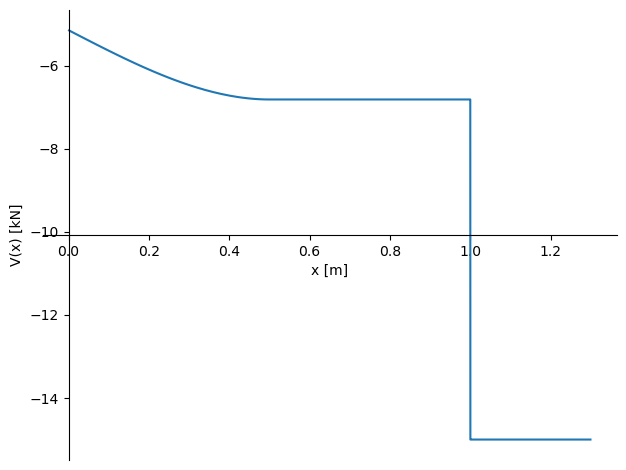

In [16]:
plot(V, x_xmin_xmax, xlabel='x [m]', ylabel='V(x) [kN]')

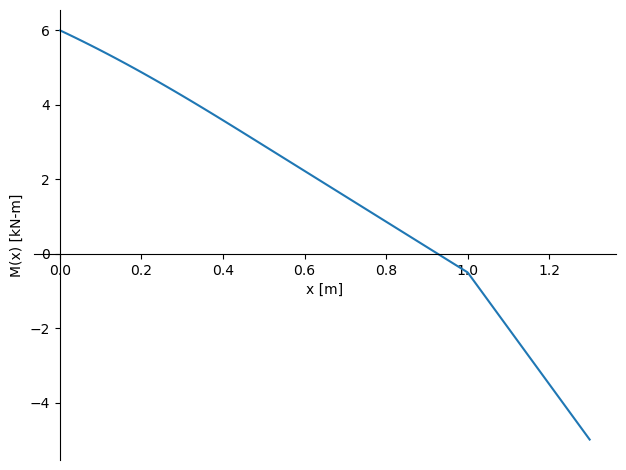

In [17]:
plot(M, x_xmin_xmax, xlabel='x [m]', ylabel='M(x) [kN-m]')

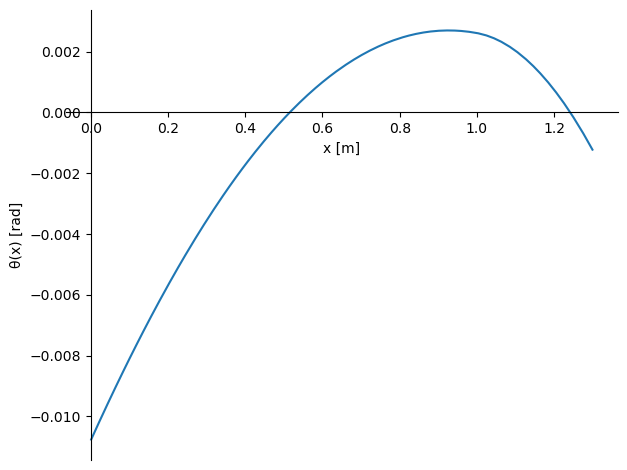

In [18]:
plot(t, x_xmin_xmax, xlabel='x [m]', ylabel='θ(x) [rad]')

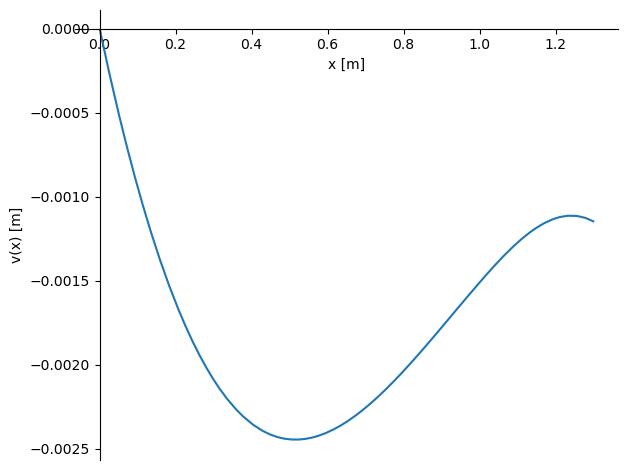

In [19]:
plot(v, x_xmin_xmax, xlabel='x [m]', ylabel='v(x) [m]')

### Se calculan las reacciones en la viga 

In [20]:
print(f"Fy(x=0) = {float(V1.subs(sol).subs(x,  0))} kN")  # reacción en x=0

Fy(x=0) = -5.145833333333333 kN


In [21]:
print(f"Fy(x=1) = {-kres*float(v1.subs(sol).subs(x,  1))} kN")  # reacción en el resorte/cimentación

Fy(x=1) = 1.8125000000000004 kN
